# PCAT with NUTS and PyMC3: Proof of Concept

This notebook implements PCAT with NUTS via PyMC3.

## Environment

Let's initialize the environment.

In [1]:
import time, sys, os
import theano

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Basic Idea

We want to probe the probabilistic distribution of all possible stars in an image. Each star $i$ has 5 parameters $\boldsymbol{\theta} \equiv \lbrace x_i, y_i, f_i, \alpha_i, \beta_i \rbrace$:
- 2 parameters $\lbrace x_i, y_i \rbrace$ which govern the 2-D position,
- 1 parameter $f_i$ for the flux, and
- 2 parameters $\lbrace \alpha_i, \beta_i \rbrace$ for the PSF, which we take to be a Moffat profile (i.e. bivariate Student distribution).

The image generation is straightforward: for a star at $\lbrace x_i, y_i \rbrace$ the flux distribution is the PSF (parameterized by $\lbrace \alpha_i, \beta_i \rbrace$) with a normalization set by $f_i$. We'll be working with 100x100 images here.

## Mock Data

In [2]:
Nx, Ny = 10, 10
Nstar = 20
fscale, fmin = 2., 10.
noise = full((Nx, Ny), 1.)
xgrid, ygrid = arange(Nx), arange(Ny)
xmesh, ymesh = meshgrid(ygrid, xgrid)

In [3]:
x_init, y_init = uniform(0, Nx-1, size=Nstar), uniform(0, Ny-1, size=Nstar) # positions
f_init = exp(exponential(scale=1./(fscale-1.), size=Nstar)) * fmin  # fluxes
#f_init = ones(Nstar) * 100.
alpha_init, beta_init = full(Nstar, 1.), full(Nstar, 2.) # PSFs
Ntheta = 5

In [4]:
def moffat(f, x, y, xb, yb, alpha, beta, return_grad=False):
    norm = (beta - 1) / (pi * alpha**2)
    dx, dy = xmesh[yb[0]:yb[1], xb[0]:xb[1]] - x, ymesh[yb[0]:yb[1], xb[0]:xb[1]] - y
    iterm = (1 + (dx**2 + dy**2) / alpha**2)
    pdf = iterm**-beta
    im = zeros((Nx, Ny))
    psf = f * norm * pdf
    im[yb[0]:yb[1], xb[0]:xb[1]] = psf
    if return_grad:
        im_grad = zeros((3, Nx, Ny))
        im_grad[:, yb[0]:yb[1], xb[0]:xb[1]] = grad_moffat(f, x, y, dx, dy, alpha, beta, psf, iterm)
        return im, im_grad
    else:
        return im

def grad_moffat(f, x, y, dx, dy, alpha, beta, psf, iterm):
    grad_x = psf * dx * (2 * beta / alpha**2 / iterm)
    grad_y = psf * dy * (2 * beta / alpha**2 / iterm)
    grad_f = psf / f
    return grad_x, grad_y, grad_f

def make_image(fs, xs, ys, alphas, betas, return_ims=False, return_grads=False):
    xc, yc, tr = xs.astype(int), ys.astype(int), (5*alphas/(betas-1.)).astype(int)
    xl, yl = xc - tr, yc - tr
    xl[xl < 0], yl[yl < 0] = 0, 0
    xh, yh = xc + tr + 1, yc + tr + 1
    xh[xh > Nx], yh[yh > Ny] = Nx, Ny
    xb, yb = c_[xl, xh], c_[yl, yh]
    if return_ims:
        if return_grads:
            ims = array([moffat(fs[i], xs[i], ys[i], xb[i], yb[i], alphas[i], betas[i], return_grad=True) 
                         for i in xrange(Nstar)])
            ims, im_grads = ims[:,0], ims[:,1]
            im = ims.sum(axis=0)
            return im, ims, im_grads
        else:
            ims = array([moffat(fs[i], xs[i], ys[i], xb[i], yb[i], alphas[i], betas[i]) for i in xrange(Nstar)])
            im = ims.sum(axis=0)
            return im, ims
    else:
        ims = array([moffat(fs[i], xs[i], ys[i], xb[i], yb[i], alphas[i], betas[i]) for i in xrange(Nstar)])
        im = ims.sum(axis=0)
        return im

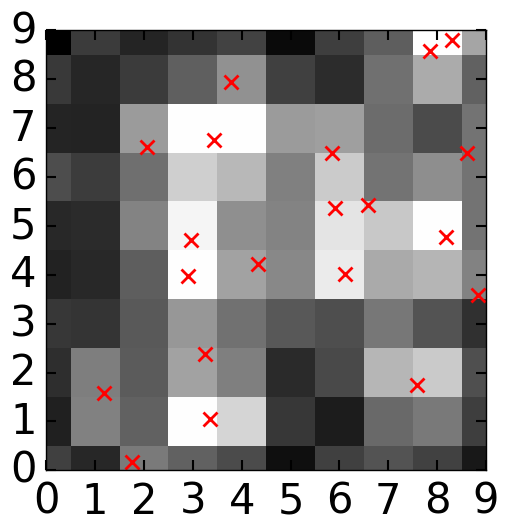

In [5]:
im = make_image(f_init, x_init, y_init, alpha_init, beta_init)
im_obs = normal(im, noise)
figure(figsize=(6, 6))
imshow(im_obs, vmax=percentile(im_obs, 95), cmap='gray', interpolation='none', origin='bottom', )
plot(x_init, y_init, 'x', markeredgewidth=2, markersize=10, color='red')
xlim([0, Nx-1])
ylim([0, Ny-1])
tight_layout()

## Statistical Model

### Likelihood

Our likelihood is simply

$$ P(\mathbf{\hat{F}} \,|\, \boldsymbol{\theta}) = \mathcal{N}\left[\Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) \:|\: \mathbf{0}, \mathbf{\hat{C}} \right] $$

where $\Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) \equiv \mathbf{F}(\boldsymbol{\theta}) - \mathbf{\hat{F}}$ is the residual image computed from our model image $\mathbf{F}(\boldsymbol{\theta})$ and observed image $\mathbf{\hat{F}}$ and $\mathbf{\hat{C}}$ is the observed covariance (which we take to be diagonal). The corresponding log-likelihood is then

$$ \ln P(\mathbf{\hat{F}} \,|\, \boldsymbol{\theta}) = -\frac{1}{2}\Delta\mathbf{\hat{F}}(\boldsymbol{\theta})^T \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) + Z_{\mathbf{\hat{F}}} $$

where $Z_{\mathbf{\hat{F}}}$ is a normalization constant.

### Prior

We assume Uniform priors in $\lbrace \mathbf{x}, \mathbf{y} \rbrace$, a truncated power law in $\mathbf{f}$, and bounded normals for $\lbrace \boldsymbol{\alpha}, \boldsymbol{\beta} \rbrace$.

## Model Setup

Let's now initialize our model in PyMC3.

In [6]:
import pymc3

In [7]:
from pymc3 import Model, Normal, Uniform, Exponential, Bound

model = Model()

with model:
    
    # priors
    xpos = Uniform('x', lower=0, upper=Nx, shape=Nstar)
    ypos = Uniform('y', lower=0, upper=Ny, shape=Nstar)
    fluxes = fmin * exp(Exponential('lnf', lam=1./(fscale-1.), shape=Nstar))
    BoundedNormal1 = Bound(Normal, lower=0.)
    alphas = BoundedNormal1('alpha', mu=1., sd=0.5, shape=Nstar)
    BoundedNormal2 = Bound(Normal, lower=1.)
    betas = BoundedNormal2('beta', mu=2., sd=0.5, shape=Nstar)
    
    def psf(f, x, y, alpha, beta):
        norm = (beta - 1) / (pi * alpha**2)
        xs, ys = xmesh-x, ymesh-y
        pdf = (1 + (xs**2 + ys**2) / alpha**2)**-beta
        im = f * norm * pdf
        return im
    
    # model
    im_mod = sum([psf(fluxes[i], xpos[i], ypos[i], alphas[i], betas[i]) for i in xrange(Nstar)], axis=0)
    
    # likelihood
    Y = Normal('image', mu=im_mod, sd=noise, observed=im_obs)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '16336' (I am process '16980')


### Generating Samples

Now that everything's set up, let's generate some samples. We'll use NUTS here.

In [8]:
from pymc3 import sample, NUTS, Slice, Metropolis

Nsamples = 1000

with model:
    x_t = log(x_init/(Nx-x_init))
    y_t = log(y_init/(Ny-y_init))
    f_t = log(log(f_init/fmin))
    alpha_t = log(alpha_init - 0.)
    beta_t = log(beta_init - 1.)
    start = {'x_interval_': x_t, 'y_interval_': y_t, 'lnf_log_': f_t, 
             'alpha_lowerbound_': alpha_t, 'beta_lowerbound_': beta_t}
    step = NUTS(vars=[xpos, ypos, fluxes, alphas, betas])
    trace = sample(Nsamples, init=None, step=step, start=start) # draw posterior samples

100%|██████████████████████████████████████| 1000/1000 [19:19<00:00,  1.25it/s]


Let's take a look at one of our samples.

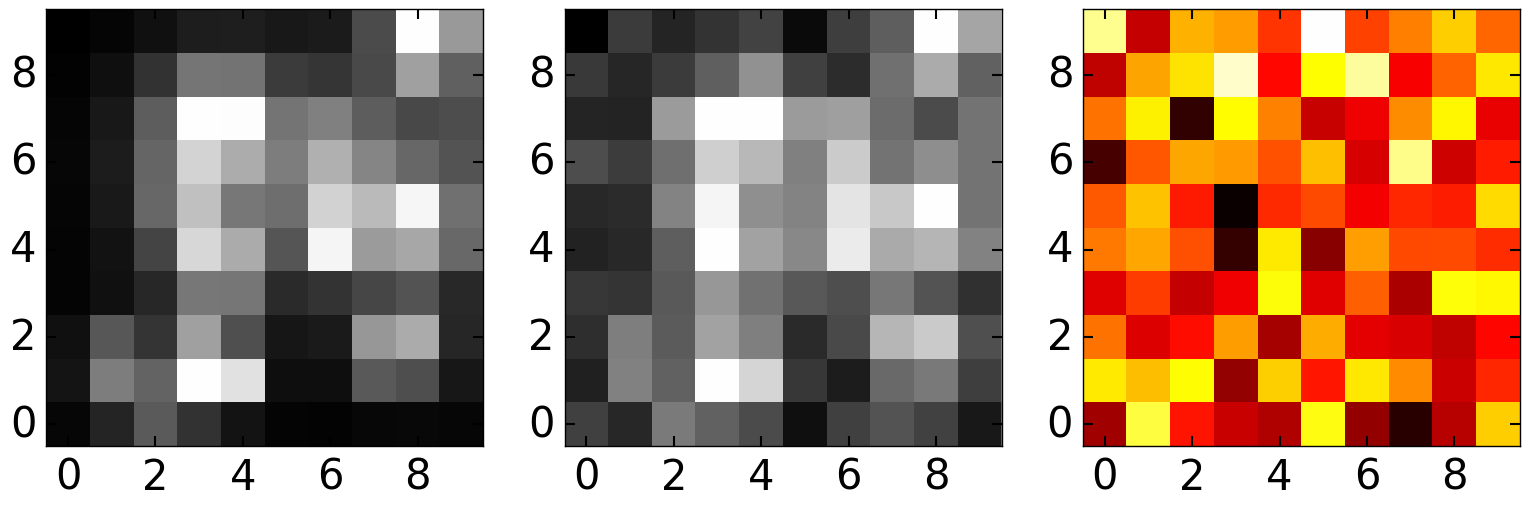

In [9]:
j = choice(Nsamples)
im = sum([psf(exp(trace[j]['lnf'])[i] * fmin, trace[j]['x'][i], trace[j]['y'][i], trace[j]['alpha'][i], trace[j]['beta'][i]) 
          for i in xrange(Nstar)], axis=0)
figure(figsize=(16,12))
subplot(1,3,1)
imshow(im, vmax=percentile(im_obs, 95), cmap='gray', interpolation='none', origin='bottom')
tight_layout()
subplot(1,3,2)
imshow(im_obs, vmax=percentile(im_obs, 95), cmap='gray', interpolation='none', origin='bottom')
tight_layout()
subplot(1,3,3)
imshow(im-im_obs, cmap='hot', interpolation='none', origin='bottom')
tight_layout()

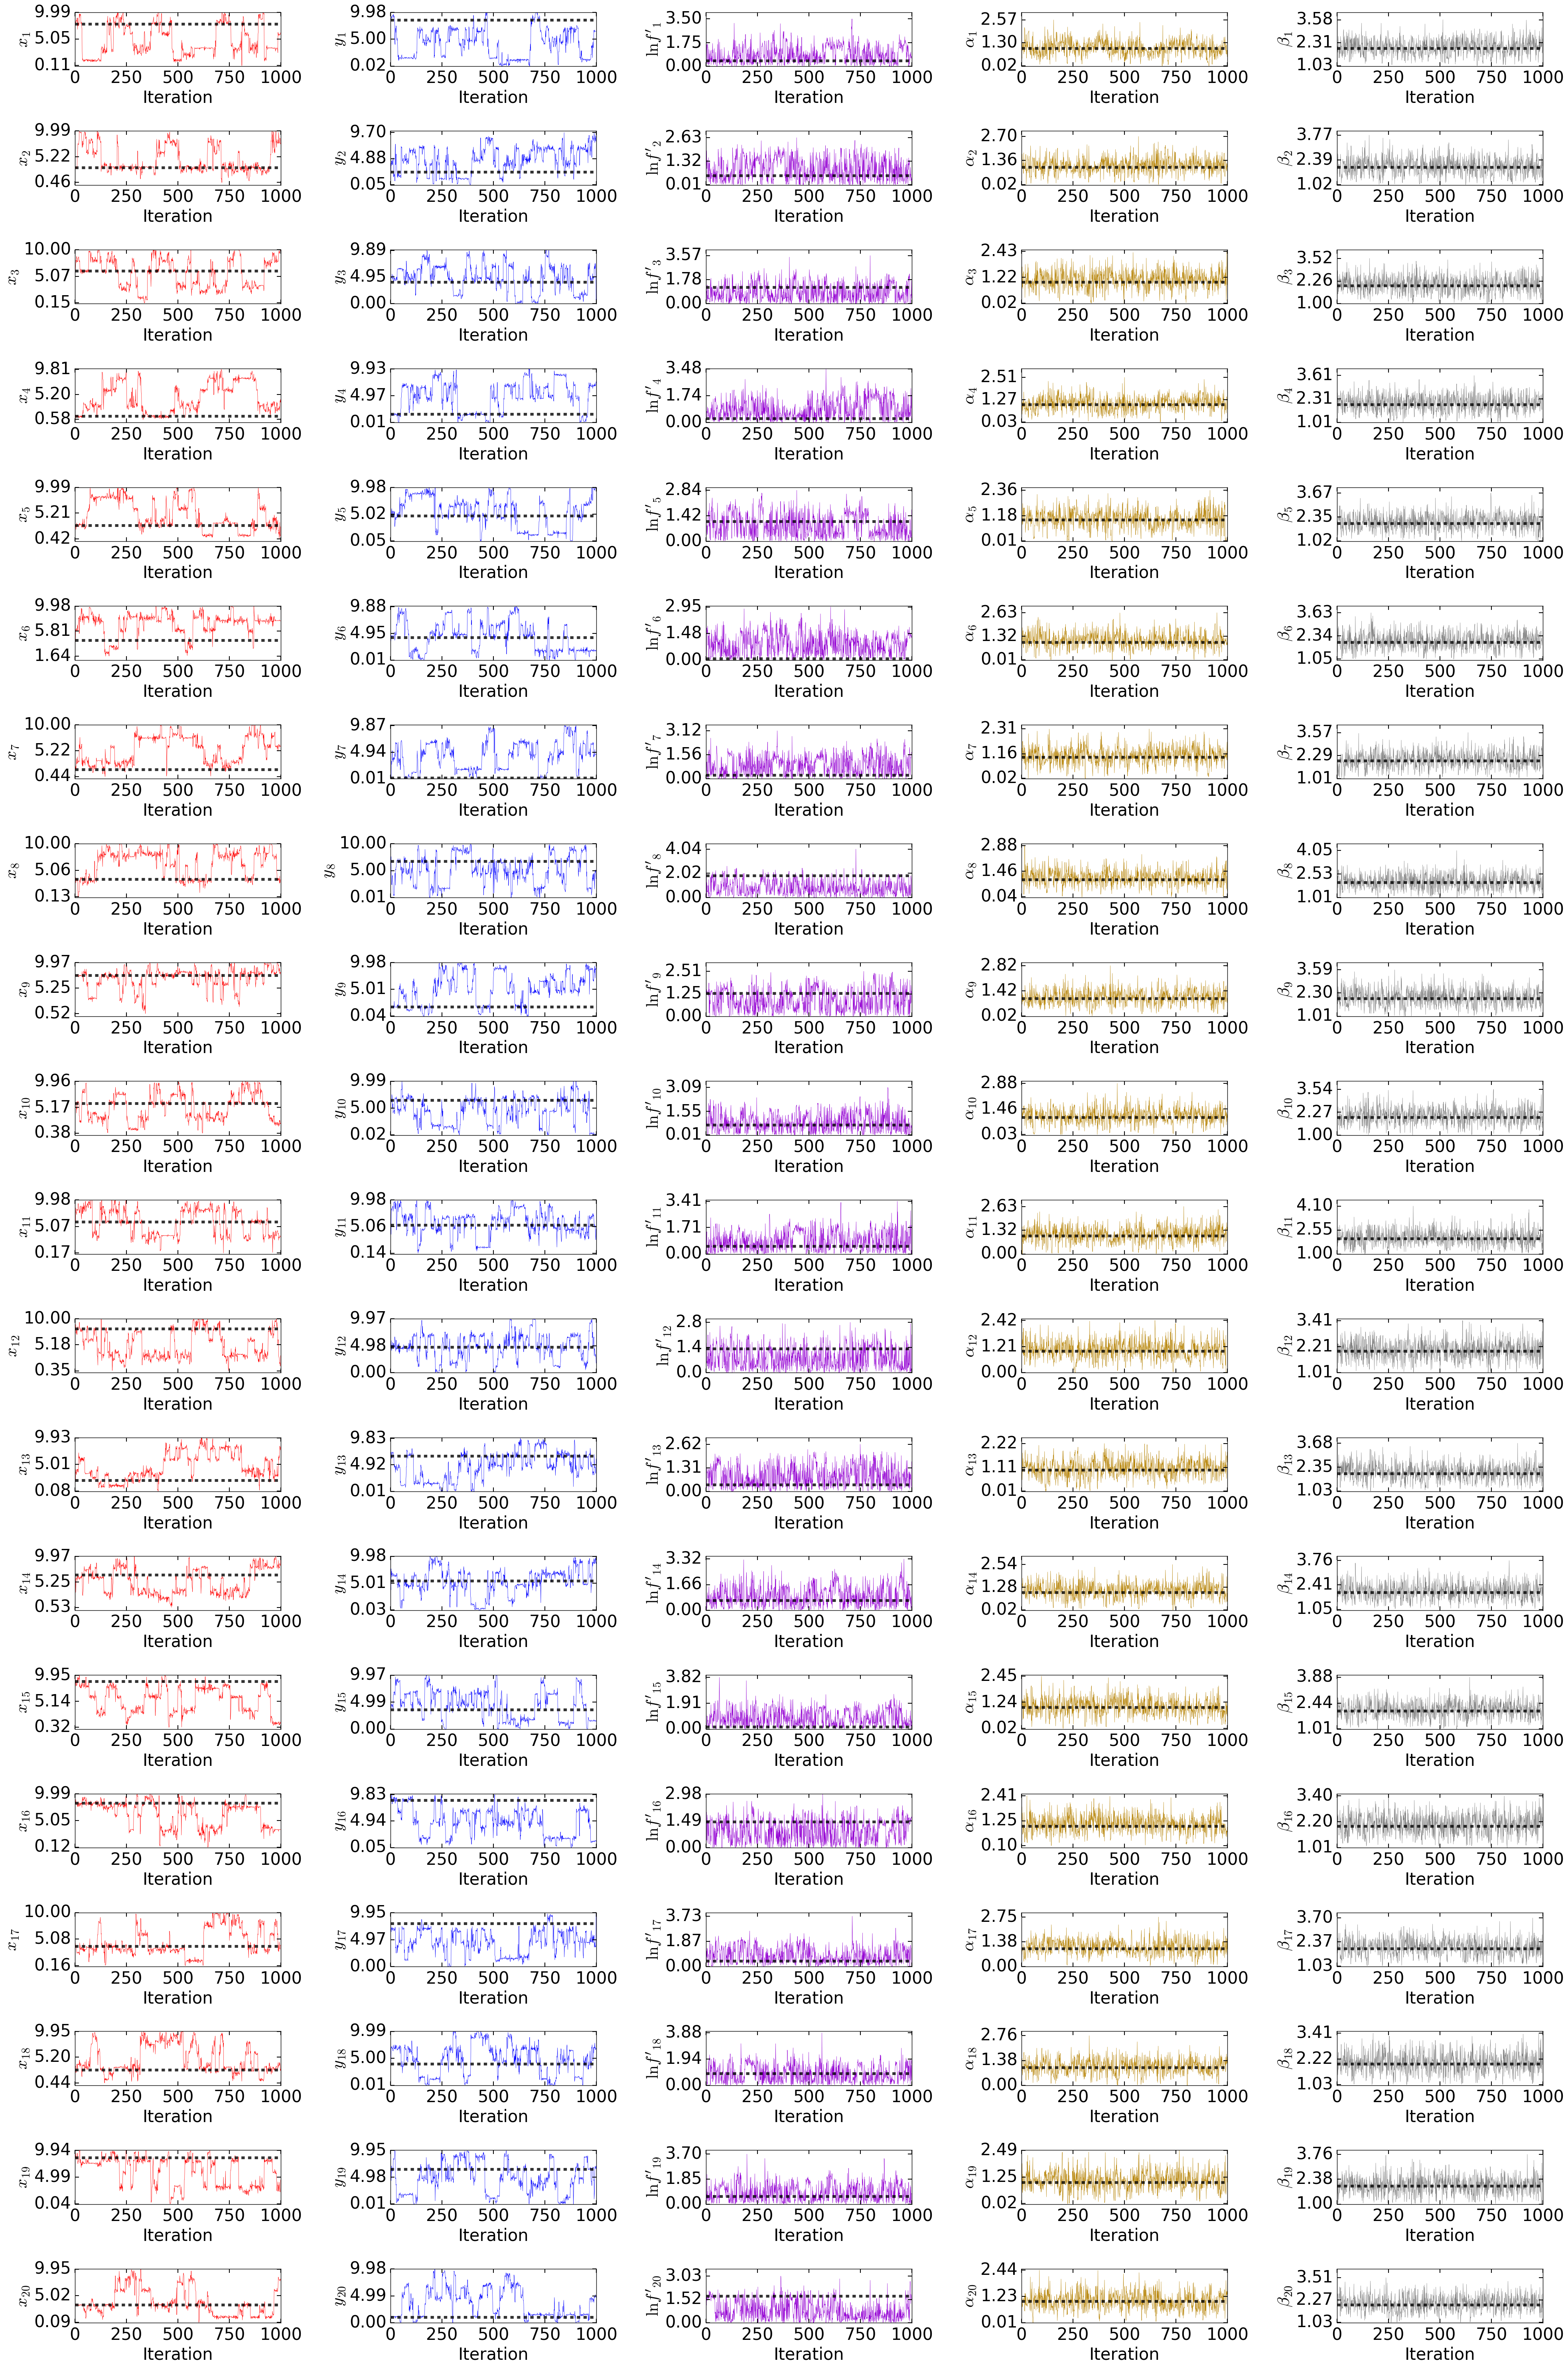

In [10]:
#### plot trace

varnames = [r'$x$', r'$y$', r'$\ln f^\prime$', r'$\alpha$', r'$\beta$']
varcolors = ['red', 'blue', 'darkviolet', 'darkgoldenrod', 'gray']
vnames = ['x', 'y', 'lnf', 'alpha', 'beta']
theta_true = array([x_init, y_init, log(f_init / fmin), alpha_init, beta_init]).T

figure(figsize=(8*Ntheta, 3*Nstar))
for i in xrange(Nstar):
    for j,v in enumerate(vnames):
        subplot(Nstar,Ntheta,Ntheta*i+j+1)
        samples = trace[v][:,i]
        plot(arange(Nsamples), samples, lw=0.5, color=varcolors[j], zorder=1)
        hlines(theta_true[i,j], 0, Nsamples, colors='black', linestyles='dashed', lw=5, alpha=0.8, zorder=2)
        ymin, ymax = samples.min(), samples.max()
        yticks(linspace(ymin, ymax, 3).round(2))
        xlabel('Iteration')
        xticks(linspace(0, Nsamples, 5))
        xlim([0, Nsamples])
        ylabel(varnames[j]+'$_{'+str(i+1)+'}$')
        tight_layout()

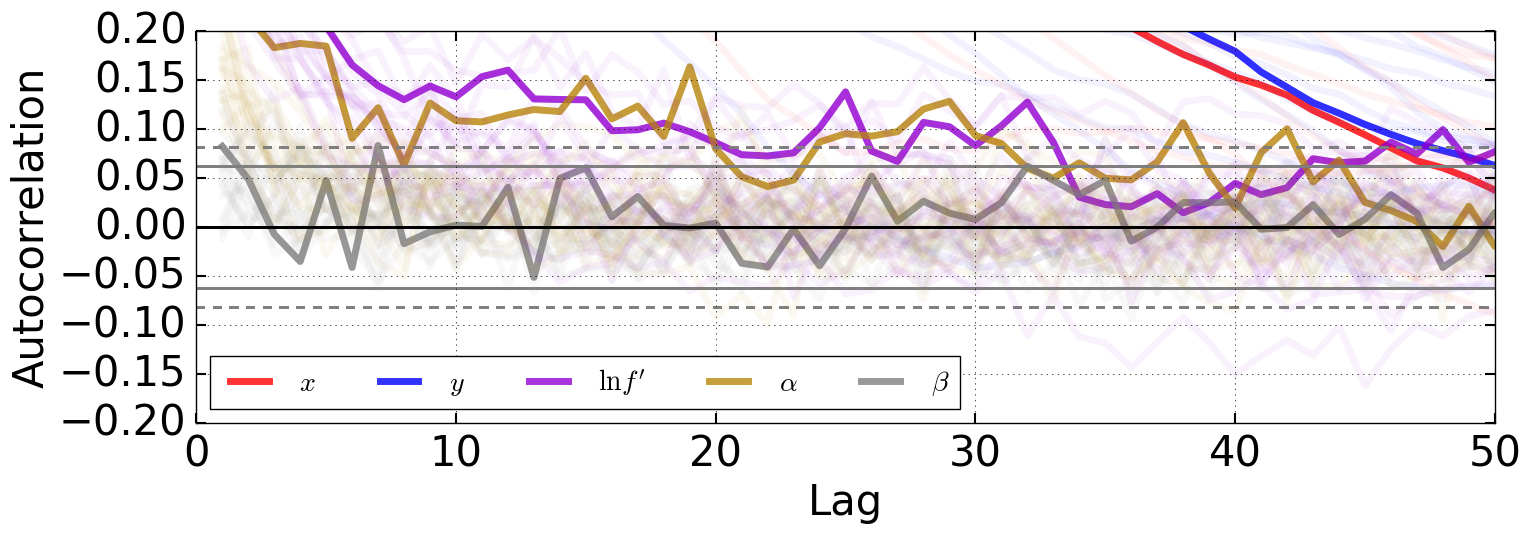

In [11]:
from pandas.tools.plotting import autocorrelation_plot # autocorrelation plot

# plot autocorrelation lag
figure(figsize=(16,6))
h = [autocorrelation_plot(trace[v][:,0], color=varcolors[i], lw=5, alpha=0.8, label=varnames[i])
     for i, v in enumerate(vnames)]
h = [[autocorrelation_plot(trace[v][:,j], color=varcolors[i], lw=5, alpha=0.05)
     for i, v in enumerate(vnames)] for j in xrange(Nstar)]
xlim([0, 50])
ylim([-0.2, 0.2])
legend(loc='best', fontsize=20, ncol=5)
tight_layout()

Let's now examine our samples.

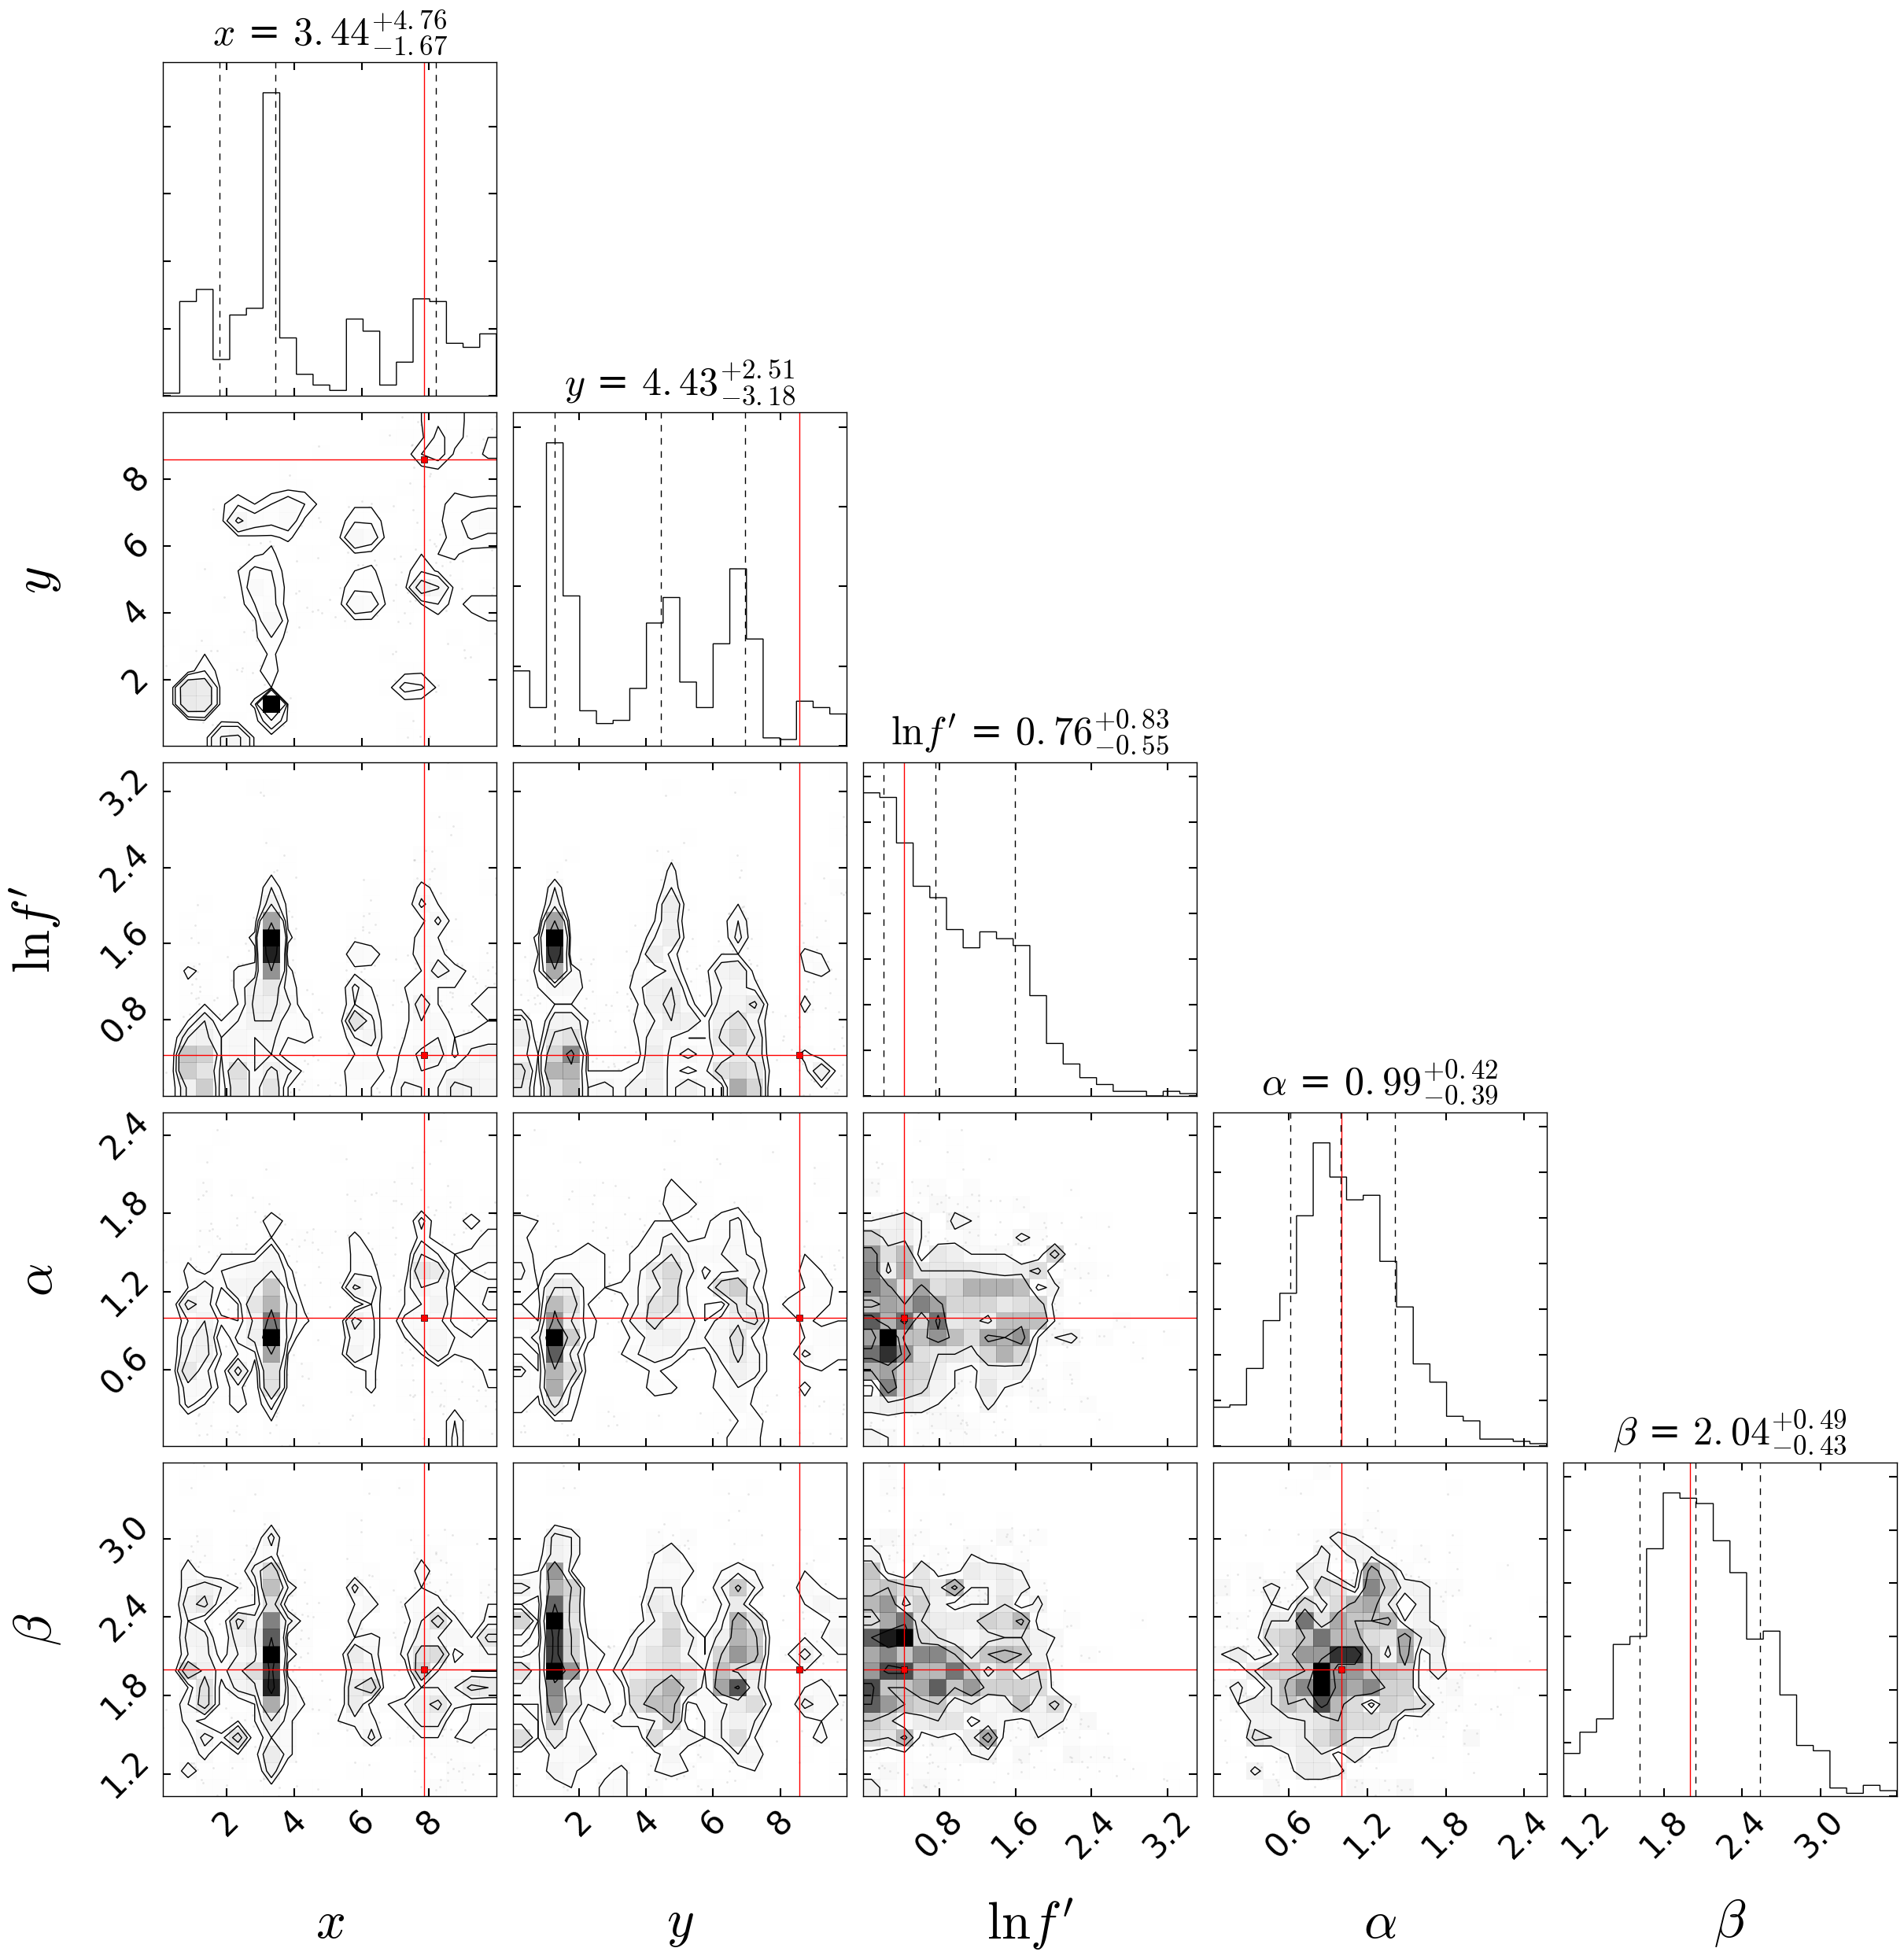

In [12]:
import corner
star_idx = 0
fig = corner.corner(c_[[trace[v][:,star_idx] for v in vnames]].T, quantiles=[.16, .50, .84],
                    labels=varnames, label_kwargs={'fontsize':48}, 
                    truths=theta_true[star_idx], truth_color='red', 
                    show_titles=True, title_kwargs={'y':1.04},
                    fig=subplots(Ntheta, Ntheta, figsize=(5*Ntheta,5*Ntheta))[0])

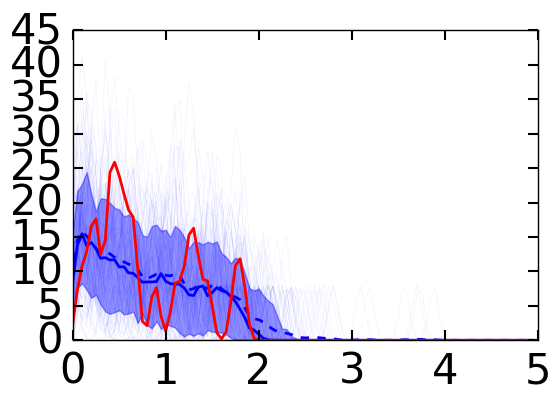

In [13]:
x_arr = arange(0, 5, 0.05)
y_true = sum([exp(-0.5*square((x_arr-mu)/0.05))/sqrt(2*pi)/0.05 for mu in theta_true[:,2]], axis=0)
y_pred = [sum([exp(-0.5*square((x_arr-mu)/0.05))/sqrt(2*pi)/0.05 for mu in trace['lnf'][j]], axis=0) 
          for j in choice(Nsamples, size=100, replace=False)]
[plot(x_arr, yp, color='blue', alpha=0.05, lw=0.5) for yp in y_pred]
plot(x_arr, percentile(y_pred, 50, axis=0), lw=2, color='blue')
plot(x_arr, mean(y_pred, axis=0), lw=2, color='blue', ls='--')
fill_between(x_arr, percentile(y_pred, 84, axis=0), percentile(y_pred, 16, axis=0), 
             color='blue', alpha=0.4)
plot(x_arr, y_true, lw=2, color='red')

In [ ]:
"""
class MyOp(theano.gof.Op):
    
    itypes = [theano.tensor.dvector, theano.tensor.dvector, theano.tensor.dvector, 
              theano.tensor.dvector, theano.tensor.dvector]
    otypes = [theano.tensor.dscalar]

    # Python implementation:
    def perform(self, node, inputs, outputs):
        fs, xs, ys, alphas, betas = inputs
        im = make_image(fs, xs, ys, alphas, betas)
        residual = im_obs - im
        sqdist = sum(square(residual/noise))
        outputs = -0.5 * sqdist

    def grad(self, inputs, g):
        im, ims, im_grads = make_image(fs, xs, ys, alphas, betas, return_ims=True, return_grads=True)
        residual = im_obs - im
        dev = residual/noise
        sqdist = sum(square(dev))
        sqdist_grad = array([dot(im_grads[i].reshape(3,-1), dev.flatten()) for i in xrange(Nstar)])
        return -sqdist_grad

from pymc3.distributions import Continuous

class lnlike(Continuous):
    def __init__(self, fs, xs, ys, alphas, betas, *args, **kwargs):
        super(lnlike, self).__init__(*args, **kwargs)
        self.mode = fs
        self.myOp = MyOp()
        
    def logp(self, inputs):
        fs, xs, ys, alphas, betas = inputs
        return self.myOp(fs, xs, ys, alphas, betas)

from pymc3 import Model, Normal, Uniform, Exponential

model = Model()

with model:
    
    # priors
    xpos = Uniform('x', lower=0, upper=Nx, shape=Nstar)
    ypos = Uniform('y', lower=0, upper=Ny, shape=Nstar)
    fluxes = fmin * exp(Exponential('lnf', lam=1./(fscale-1.), shape=Nstar))
    alphas = alpha_init
    betas = beta_init
    
    # likelihood
    Y = lnlike('image', alphas=alphas, betas=betas, xs=xpos, ys=ypos, fs=fluxes)
"""